#"MODELO PREDICTOR DE PINGÜINOS"


#Importaciones

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib
from sklearn.preprocessing import LabelEncoder


pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

## 2. CARGAR Y EXPLORAR LOS DATOS

Cargamos el dataset y damos un primer vistazo a su estructura y a los valores nulos.

In [ ]:
# ==============================================================================
# 2. CARGAR Y EXPLORAR LOS DATOS (VERSIÓN CERO INSTALACIÓN)
# ==============================================================================
# Cargamos el dataset directamente desde su URL en GitHub.
# Esto elimina la necesidad de instalar la librería 'palmerpenguins'.

url = 'https://raw.githubusercontent.com/allisonhorst/palmerpenguins/main/inst/extdata/penguins.csv'
df = pd.read_csv(url)

print("Dataset original cargado desde la web:")
print(df.head())
print("\nValores nulos por columna:")
print(df.isna().sum().sort_values(ascending=False))

Dataset original cargado desde la web:
  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g     sex  year
0  Adelie  Torgersen            39.1           18.7              181.0       3750.0    male  2007
1  Adelie  Torgersen            39.5           17.4              186.0       3800.0  female  2007
2  Adelie  Torgersen            40.3           18.0              195.0       3250.0  female  2007
3  Adelie  Torgersen             NaN            NaN                NaN          NaN     NaN  2007
4  Adelie  Torgersen            36.7           19.3              193.0       3450.0  female  2007

Valores nulos por columna:
sex                  11
bill_depth_mm         2
flipper_length_mm     2
bill_length_mm        2
body_mass_g           2
island                0
species               0
year                  0
dtype: int64


In [ ]:
display(df)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1-nUPGRTQ6kDsOQh9zugjKXeKusx3tbteXBYuGSweSTc/edit#gid=0


### Información general y valores nulos

In [ ]:
# Dimensiones y tipos
print(df.shape)
df.info()

(344, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 21.6+ KB


# Eliminar null

In [ ]:
df_copia=df.copy()
df_copia.dropna(inplace=True)
print(df.shape)


(344, 8)


#One hot encoding

In [ ]:
# Convertimos las columnas categóricas a numéricas usando 1s y 0s
df_copia = pd.get_dummies(df_copia, columns=['island', 'sex'], drop_first=True, dtype=int)

print("Dataset preprocesado con 1s y 0s:")
print(df_copia.head())

Dataset preprocesado con 1s y 0s:
  species  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  year  island_Dream  island_Torgersen  \
0  Adelie            39.1           18.7              181.0       3750.0  2007             0                 1   
1  Adelie            39.5           17.4              186.0       3800.0  2007             0                 1   
2  Adelie            40.3           18.0              195.0       3250.0  2007             0                 1   
4  Adelie            36.7           19.3              193.0       3450.0  2007             0                 1   
5  Adelie            39.3           20.6              190.0       3650.0  2007             0                 1   

   sex_male  
0         1  
1         0  
2         0  
4         0  
5         1  


## 4. VISUALIZACIÓN RÁPIDA (SOBRE DATOS PREPROCESADOS)

Ahora que todos los datos son numéricos, podemos visualizar sus distribuciones.

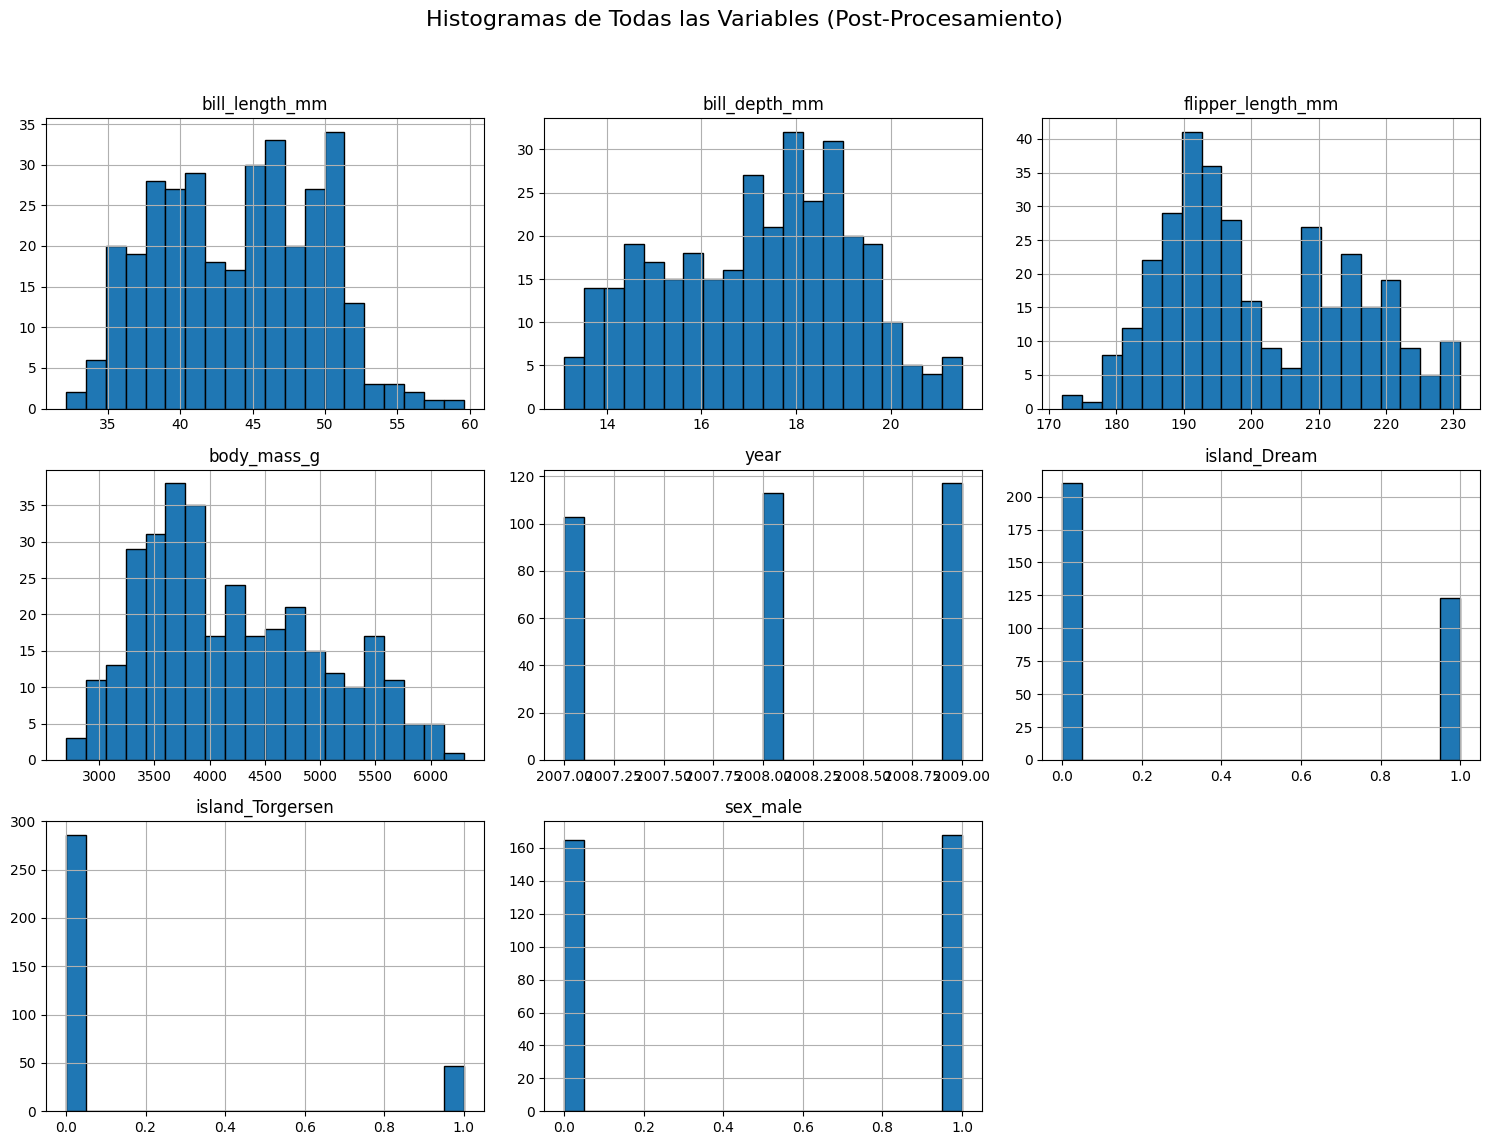

In [ ]:
# Excluimos la columna objetivo 'species' de las features a graficar
features_to_plot = df_copia.drop(columns=['species']).columns

df_copia[features_to_plot].hist(figsize=(15, 12), bins=20, edgecolor='black')
plt.suptitle('Histogramas de Todas las Variables (Post-Procesamiento)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#Matriz de correlacción

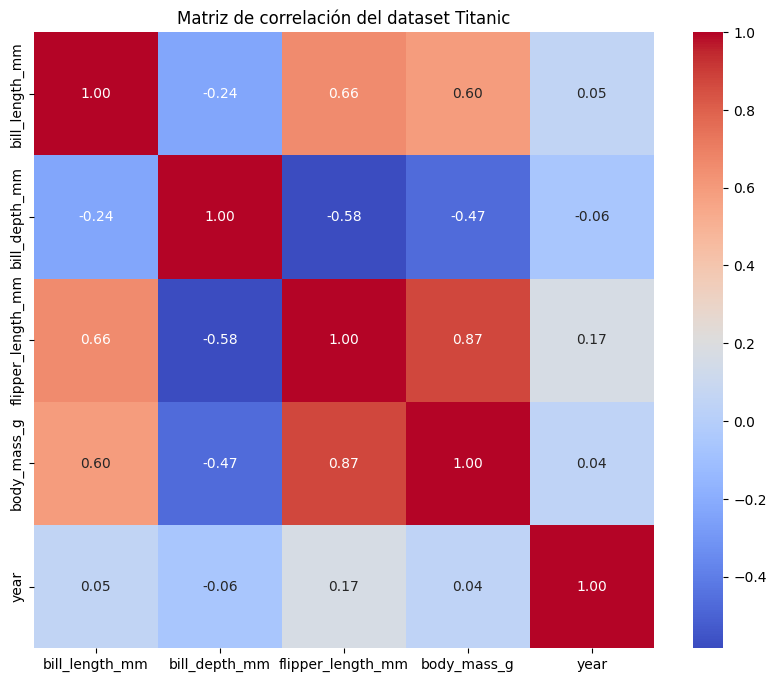

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar solo las columnas numéricas para la correlación
numeric_df = df.select_dtypes(include=np.number)

# Calcular la matriz de correlación
correlation_matrix = numeric_df.corr()

# Visualizar la matriz de correlación con un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación del dataset Titanic')
plt.show()

In [ ]:
cols_to_drop = ['flipper_length_mm']
df_copia = df_copia.drop(columns=cols_to_drop)
df_copia.head()

,species,bill_length_mm,bill_depth_mm,body_mass_g,year,island_Dream,island_Torgersen,sex_male
0,Adelie,39.1,18.7,3750.0,2007,0,1,1
1,Adelie,39.5,17.4,3800.0,2007,0,1,0
2,Adelie,40.3,18.0,3250.0,2007,0,1,0
4,Adelie,36.7,19.3,3450.0,2007,0,1,0
5,Adelie,39.3,20.6,3650.0,2007,0,1,1


## SEPARACIÓN DE DATOS (SOBRE DATOS ORIGINALES)


In [ ]:
# Definimos X (features) y y (etiqueta)
target = 'species'
X = df_copia.drop(columns=[target])
y = df_copia[target]


# 1. Crear una instancia del codificador de etiquetas
label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y)


# Primero train+temp y test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Luego validación y test por mitades de ese 40%
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print('Tamaños:')
print('Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)

Tamaños:
Train: (199, 7) Val: (67, 7) Test: (67, 7)


#Entrenamiento

## Red neuronal artificial

Escalando los datos de entrenamiento...

Entrenando la Red Neuronal (MLP)...
Iteration 1, loss = 1.04344379
Validation score: 0.700000
Iteration 2, loss = 0.99776499
Validation score: 0.700000
Iteration 3, loss = 0.95452886
Validation score: 0.700000
Iteration 4, loss = 0.91337873
Validation score: 0.700000
Iteration 5, loss = 0.87424880
Validation score: 0.800000
Iteration 6, loss = 0.83676447
Validation score: 0.850000
Iteration 7, loss = 0.80099067
Validation score: 0.900000
Iteration 8, loss = 0.76685849
Validation score: 0.900000
Iteration 9, loss = 0.73413076
Validation score: 0.900000
Iteration 10, loss = 0.70285132
Validation score: 0.950000
Iteration 11, loss = 0.67290645
Validation score: 0.950000
Iteration 12, loss = 0.64421351
Validation score: 0.950000
Iteration 13, loss = 0.61656518
Validation score: 1.000000
Iteration 14, loss = 0.58985125
Validation score: 1.000000
Iteration 15, loss = 0.56398458
Validation score: 1.000000
Iteration 16, loss = 0.53890450
Validation scor

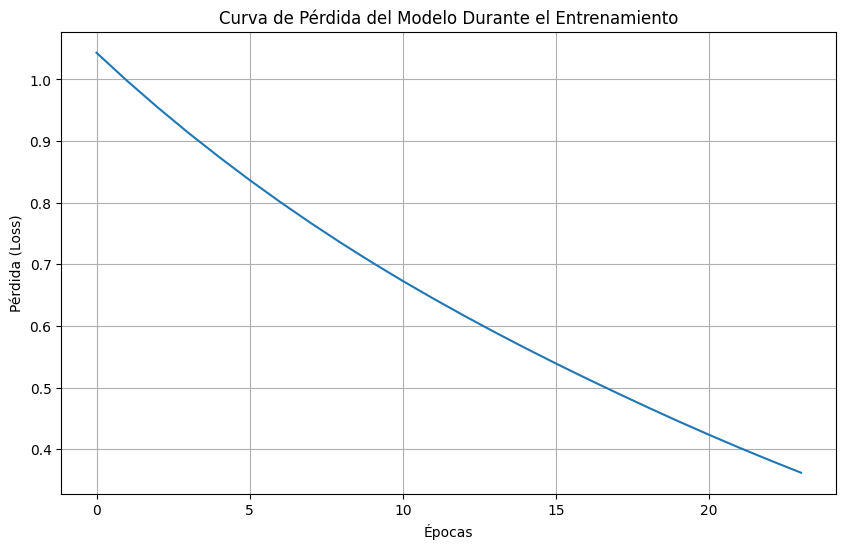

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier


# 1. Crear las instancias
scaler = StandardScaler()
model_mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    max_iter=300,
    random_state=42,
    verbose=True,
    early_stopping=True
)

# 2. Escalar los datos de ENTRENAMIENTO
print("Escalando los datos de entrenamiento...")
X_train_scaled = scaler.fit_transform(X_train)

# 3. Entrenar la Red Neuronal con los datos escalados
print("\nEntrenando la Red Neuronal (MLP)...")
model_mlp.fit(X_train_scaled, y_train)
print("¡Entrenamiento completado!")


# --- Visualización de la Curva de Aprendizaje ---
# Accedemos al atributo .loss_curve_ directamente desde el modelo
loss_curve = model_mlp.loss_curve_

plt.figure(figsize=(10, 6))
plt.plot(loss_curve)
plt.title('Curva de Pérdida del Modelo Durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.grid(True)
plt.show()

#Evaluación

## MlP

Escalando los datos de prueba...
Realizando predicciones...

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.90      0.93      0.92        30
           1       0.83      0.77      0.80        13
           2       1.00      1.00      1.00        24

    accuracy                           0.93        67
   macro avg       0.91      0.90      0.91        67
weighted avg       0.92      0.93      0.92        67


--- Matriz de Confusión ---


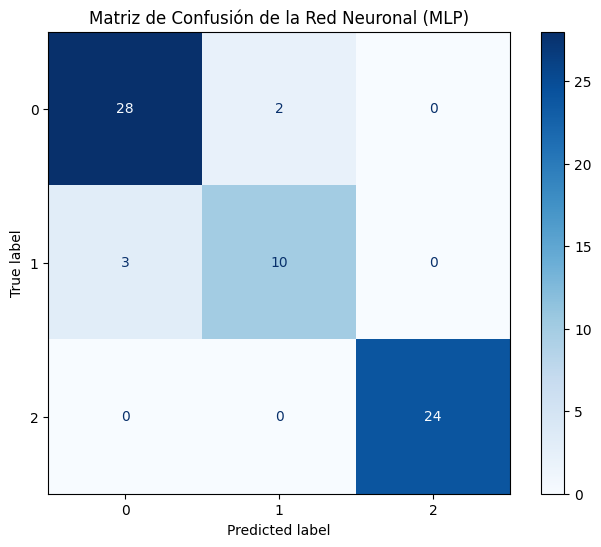

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Escalar los datos de PRUEBA con el escalador que ya aprendió de los datos de entrenamiento
print("Escalando los datos de prueba...")
X_test_scaled = scaler.transform(X_test)

# 2. Hacer predicciones en el conjunto de prueba ya escalado
print("Realizando predicciones...")
y_pred = model_mlp.predict(X_test_scaled)


# 3. Imprimir el Reporte de Clasificación
#    Este reporte incluye precisión, recall, y el f1-score para cada clase.
print("\n--- Reporte de Clasificación ---")
report = classification_report(y_test, y_pred)
print(report)

# 4. Mostrar la Matriz de Confusión
#    Esto nos permite ver visualmente qué clases el modelo confunde más a menudo.
print("\n--- Matriz de Confusión ---")
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    cmap='Blues',
    ax=ax
)
plt.title('Matriz de Confusión de la Red Neuronal (MLP)')
plt.show()

#Decision tree

Entrenando el Árbol de Decisión...
¡Modelo entrenado!

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       0.76      1.00      0.87        13
           2       1.00      0.96      0.98        24

    accuracy                           0.94        67
   macro avg       0.92      0.95      0.93        67
weighted avg       0.95      0.94      0.94        67


--- Matriz de Confusión ---


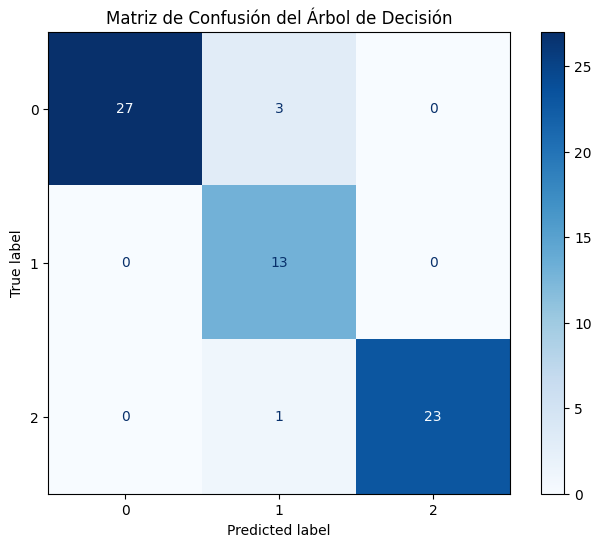

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# 1. Crear la instancia del modelo
model_tree = DecisionTreeClassifier(
    max_depth=5,       # Profundidad máxima para evitar que el árbol crezca demasiado y se sobreajuste
    random_state=42
)

# 2. Entrenar el Árbol de Decisión con los datos de entrenamiento YA escalados
print("Entrenando el Árbol de Decisión...")
model_tree.fit(X_train_scaled, y_train)
print("¡Modelo entrenado!")

# 3. Escalar los datos de prueba para la evaluación
X_test_scaled = scaler.transform(X_test)

# 4. Hacer predicciones en el conjunto de prueba
y_pred = model_tree.predict(X_test_scaled)

# --- Visualización y Reporte del Rendimiento ---

# Reporte de Clasificación: Muestra métricas clave como precisión, recall y f1-score
print("\n--- Reporte de Clasificación ---")
report = classification_report(y_test, y_pred)
print(report)

# Matriz de Confusión: Muestra visualmente cuántas predicciones fueron correctas e incorrectas por clase
print("\n--- Matriz de Confusión ---")
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay.from_estimator(
    model_tree,
    X_test_scaled,
    y_test,
    cmap='Blues',
    ax=ax
)
plt.title('Matriz de Confusión del Árbol de Decisión')
plt.show()

#PCA

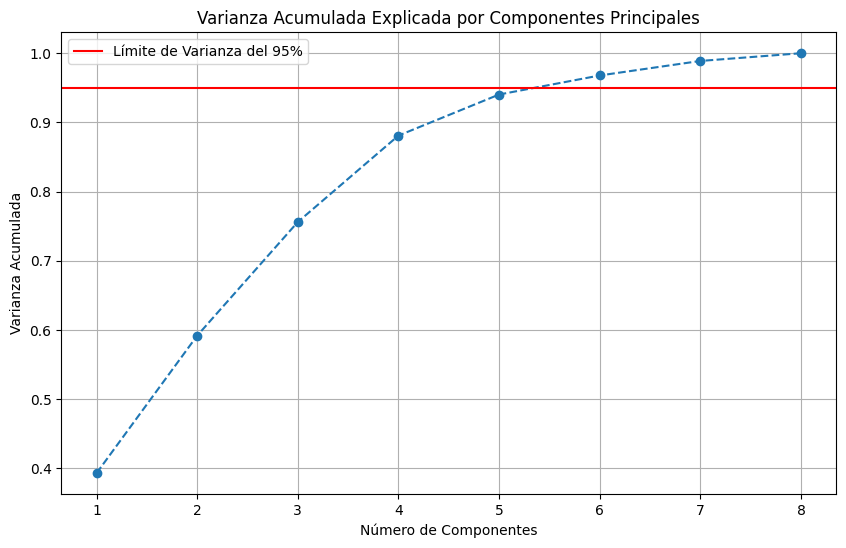

Analiza la gráfica para decidir el número de componentes. Un buen punto de partida es elegir el número que captura ~95% de la varianza.

Dimensiones de los datos originales: (333, 8)
Dimensiones de los datos después de PCA: (333, 4)

¡Datos transformados con PCA y listos para entrenar!
Tamaño de X_train_pca: (266, 4)
Tamaño de X_test_pca: (67, 4)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split



# --- 1. Escalar los datos ---
# PCA es sensible a la escala de las variables, por lo que siempre
# debemos escalar los datos primero.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# --- 2. Aplicar PCA y calcular la Varianza Acumulada ---
# Primero, aplicamos PCA sin definir un número de componentes para
# poder analizar cuánta varianza explica cada uno.
pca_analysis = PCA()
pca_analysis.fit(X_scaled)

# Calculamos la suma acumulada de la varianza explicada
cumulative_variance = np.cumsum(pca_analysis.explained_variance_ratio_)


# --- 3. Graficar la Varianza Acumulada ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Varianza Acumulada Explicada por Componentes Principales')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='-', label='Límite de Varianza del 95%')
plt.legend()
plt.show()

print("Analiza la gráfica para decidir el número de componentes. Un buen punto de partida es elegir el número que captura ~95% de la varianza.")

n_components_elegido = 4
pca_final = PCA(n_components=n_components_elegido)

# Transformamos los datos escalados a los nuevos componentes principales
X_pca = pca_final.fit_transform(X_scaled)

print(f"\nDimensiones de los datos originales: {X_scaled.shape}")
print(f"Dimensiones de los datos después de PCA: {X_pca.shape}")


# --- 5. Dividir los datos transformados por PCA en entrenamiento y prueba ---
X_train_pca, X_test_pca, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

print("\n¡Datos transformados con PCA y listos para entrenar!")
print(f"Tamaño de X_train_pca: {X_train_pca.shape}")
print(f"Tamaño de X_test_pca: {X_test_pca.shape}")


Entrenando la Red Neuronal (MLP)...
Iteration 1, loss = 1.22264758
Validation score: 0.333333
Iteration 2, loss = 1.10444297
Validation score: 0.518519
Iteration 3, loss = 0.99952599
Validation score: 0.592593
Iteration 4, loss = 0.90634880
Validation score: 0.666667
Iteration 5, loss = 0.82544389
Validation score: 0.740741
Iteration 6, loss = 0.75289034
Validation score: 0.740741
Iteration 7, loss = 0.68791672
Validation score: 0.740741
Iteration 8, loss = 0.62992177
Validation score: 0.814815
Iteration 9, loss = 0.57865109
Validation score: 0.814815
Iteration 10, loss = 0.53285732
Validation score: 0.814815
Iteration 11, loss = 0.49212757
Validation score: 0.814815
Iteration 12, loss = 0.45596957
Validation score: 0.851852
Iteration 13, loss = 0.42403078
Validation score: 0.851852
Iteration 14, loss = 0.39487198
Validation score: 0.851852
Iteration 15, loss = 0.36880628
Validation score: 0.851852
Iteration 16, loss = 0.34490364
Validation score: 0.851852
Iteration 17, loss = 0.32322

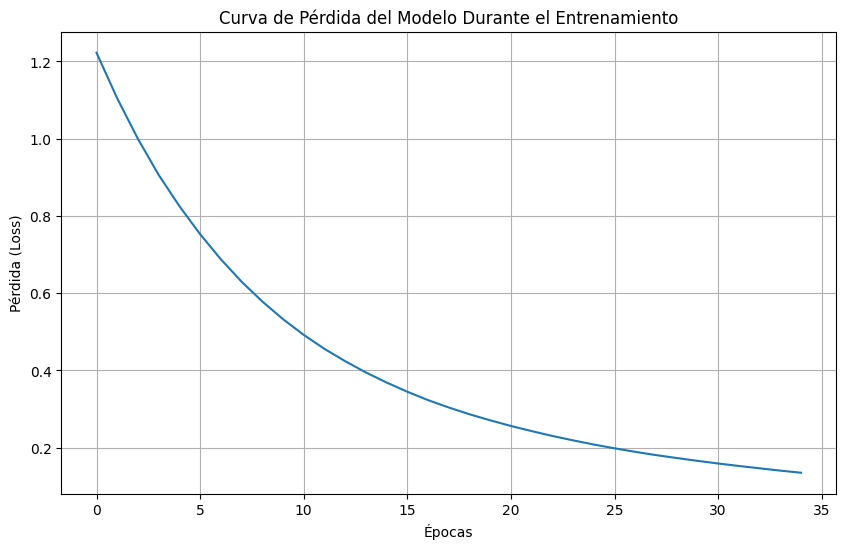

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier


# 1. Crear las instancias
scaler = StandardScaler()
model_mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    max_iter=300,
    random_state=42,
    verbose=True,
    early_stopping=True
)


# 3. Entrenar la Red Neuronal con los datos escalados
print("\nEntrenando la Red Neuronal (MLP)...")
model_mlp.fit(X_train_pca, y_train)
print("¡Entrenamiento completado!")


# --- Visualización de la Curva de Aprendizaje ---
# Accedemos al atributo .loss_curve_ directamente desde el modelo
loss_curve = model_mlp.loss_curve_

plt.figure(figsize=(10, 6))
plt.plot(loss_curve)
plt.title('Curva de Pérdida del Modelo Durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.grid(True)
plt.show()

Realizando predicciones...

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        29
           1       1.00      0.86      0.92        14
           2       1.00      1.00      1.00        24

    accuracy                           0.97        67
   macro avg       0.98      0.95      0.96        67
weighted avg       0.97      0.97      0.97        67


--- Matriz de Confusión ---


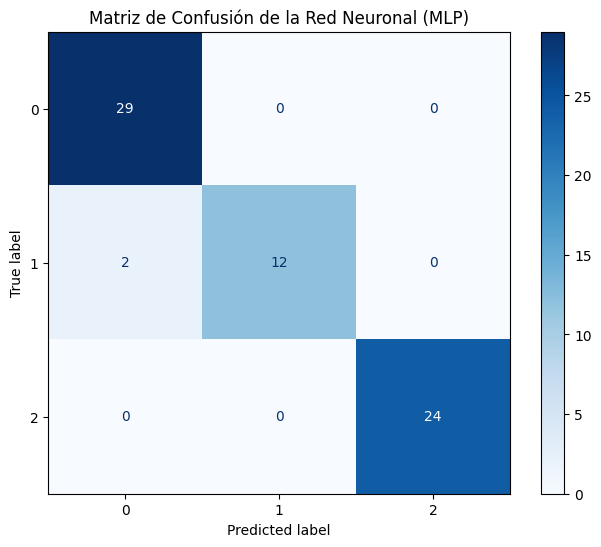

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# 2. Hacer predicciones en el conjunto de prueba ya escalado
print("Realizando predicciones...")
y_pred = model_mlp.predict(X_test_pca)


# 3. Imprimir el Reporte de Clasificación
#    Este reporte incluye precisión, recall, y el f1-score para cada clase.
print("\n--- Reporte de Clasificación ---")
report = classification_report(y_test, y_pred)
print(report)

# 4. Mostrar la Matriz de Confusión
#    Esto nos permite ver visualmente qué clases el modelo confunde más a menudo.
print("\n--- Matriz de Confusión ---")
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    cmap='Blues',
    ax=ax
)
plt.title('Matriz de Confusión de la Red Neuronal (MLP)')
plt.show()

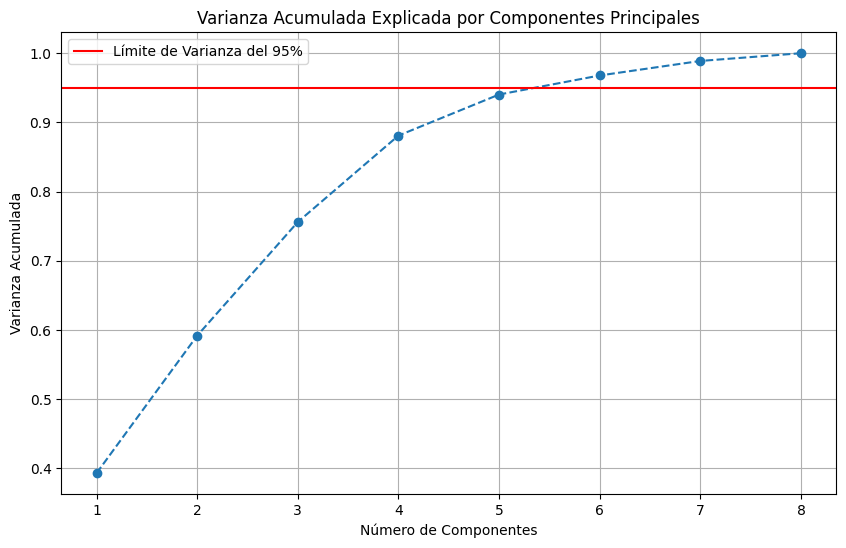

Analiza la gráfica para decidir el número de componentes. Un buen punto de partida es elegir el número que captura ~95% de la varianza.

Dimensiones de los datos originales: (333, 8)
Dimensiones de los datos después de PCA: (333, 4)

¡Datos transformados con PCA y listos para entrenar!
Tamaño de X_train_pca: (266, 4)
Tamaño de X_test_pca: (67, 4)
Accuracy de Regresión Logística: 1.000


In [ ]:
from sklearn.linear_model import LogisticRegression


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split



# --- 1. Escalar los datos ---
# PCA es sensible a la escala de las variables, por lo que siempre
# debemos escalar los datos primero.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# --- 2. Aplicar PCA y calcular la Varianza Acumulada ---
# Primero, aplicamos PCA sin definir un número de componentes para
# poder analizar cuánta varianza explica cada uno.
pca_analysis = PCA()
pca_analysis.fit(X_scaled)

# Calculamos la suma acumulada de la varianza explicada
cumulative_variance = np.cumsum(pca_analysis.explained_variance_ratio_)


# --- 3. Graficar la Varianza Acumulada ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Varianza Acumulada Explicada por Componentes Principales')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='-', label='Límite de Varianza del 95%')
plt.legend()
plt.show()

print("Analiza la gráfica para decidir el número de componentes. Un buen punto de partida es elegir el número que captura ~95% de la varianza.")

n_components_elegido = 4
pca_final = PCA(n_components=n_components_elegido)

# Transformamos los datos escalados a los nuevos componentes principales
X_pca = pca_final.fit_transform(X_scaled)

print(f"\nDimensiones de los datos originales: {X_scaled.shape}")
print(f"Dimensiones de los datos después de PCA: {X_pca.shape}")


# --- 5. Dividir los datos transformados por PCA en entrenamiento y prueba ---
X_train_pca, X_test_pca, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

print("\n¡Datos transformados con PCA y listos para entrenar!")
print(f"Tamaño de X_train_pca: {X_train_pca.shape}")
print(f"Tamaño de X_test_pca: {X_test_pca.shape}")
# Crear y entrenar el modelo
model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train_pca, y_train)


# Evaluar
accuracy_lr = model_lr.score(X_test_pca, y_test)
print(f"Accuracy de Regresión Logística: {accuracy_lr:.3f}")

In [ ]:
print(X_train_scaled.shape)

(199, 8)


#Descargar modelos

In [ ]:
import joblib

# Guardar el modelo de Red Neuronal (MLP)
joblib.dump(model_mlp, 'modelo_mlp.pkl')

# Guardar el objeto scaler que fue ajustado
joblib.dump(scaler, 'scaler.pkl')

print("¡Modelo y Scaler guardados exitosamente!")

# Celda para descargar los archivos (ejecutar después de guardar)
from google.colab import files

files.download('modelo_mlp.pkl')
files.download('scaler.pkl')

¡Modelo y Scaler guardados exitosamente!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>